### 3.4. Implementación de la línea base con regresión lineal

Para establecer una línea base en el análisis predictivo de los precios de acciones, se implementó un modelo de **regresión lineal simple**.  
El objetivo del modelo fue predecir el **precio de cierre ajustado (Close)** del día siguiente a partir de las variables preprocesadas e indicadores técnicos calculados.

La regresión lineal se seleccionó por su **simplicidad e interpretabilidad**, y sirve como referencia para comparar con modelos más avanzados (como LSTM o GRU).

**Variable objetivo (Target):**  
El precio de cierre del día siguiente, obtenido desplazando la columna *Close* una posición hacia arriba en el conjunto de datos.

**Características (X):**  
Incluyen todas las columnas de precios e indicadores técnicos (*SMA₅, EMA₁₀, RSI₁₄, Volatilidad₁₀, ATR₁₄*, etc.), además de las variables originales (*Open, High, Low, Volume*).

**División de los datos:**  
El conjunto se dividió en dos subconjuntos:  
- Entrenamiento (80 %), para ajustar los parámetros del modelo.  
- Prueba (20 %), para evaluar el rendimiento.  
Se mantuvo el orden temporal para evitar fuga de información.

**Entrenamiento del modelo:**  
Se utilizó la implementación de regresión lineal de *scikit-learn*, que minimiza la suma de los errores cuadrados entre las predicciones y los valores reales.

Este modelo proporciona una referencia inicial (*baseline*) para comparar el rendimiento de modelos más complejos en fases posteriores.


In [1]:
# ============================================
# 0) Imports y rutas
# ============================================
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

IN_DIR = Path("../data/processed/ready_for_modeling")
OUT_DIR = Path("../results/baseline_regression")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TICKERS = ["BBVA", "SAN"]

# ============================================
# 1) Función para preparar datos
# ============================================
def prepare_data(df: pd.DataFrame, target_col: str = "Close", test_size: float = 0.2):
    """
    Crea el target (Close del día siguiente), divide en train/test manteniendo orden temporal.
    """
    df = df.copy()
    
    # Target = precio de cierre del día siguiente
    df["Target"] = df[target_col].shift(-1)
    
    # Eliminar la última fila (porque no tiene Target)
    df = df.dropna(subset=["Target"])
    
    # Separar variables predictoras (X) y objetivo (y)
    X = df.drop(columns=["Target"])
    y = df["Target"]
    
    # División 80%-20% respetando el orden temporal
    split_idx = int(len(df) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    return X_train, X_test, y_train, y_test

# ============================================
# 2) Entrenamiento y evaluación
# ============================================
results = []
for t in TICKERS:
    path = IN_DIR / f"{t}_final_ready.csv"
    df = pd.read_csv(path, parse_dates=["Date"], index_col="Date")
    
    X_train, X_test, y_train, y_test = prepare_data(df)
    
    # Entrenamiento del modelo lineal
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métricas
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)
    
    results.append({
        "Ticker": t,
        "MAE_train": mae_train, "MAE_test": mae_test,
        "RMSE_train": rmse_train, "RMSE_test": rmse_test,
        "R2_train": r2_train, "R2_test": r2_test
    })
    
    # Guardar predicciones en CSV
    preds = pd.DataFrame({
        "Date": y_test.index,
        "Real_Close": y_test.values,
        "Predicted_Close": y_pred_test
    }).set_index("Date")
    preds.to_csv(OUT_DIR / f"{t}_baseline_predictions.csv")

# ============================================
# 3) Resultados
# ============================================
df_results = pd.DataFrame(results)
df_results.to_csv(OUT_DIR / "baseline_metrics.csv", index=False)
print("✅ Resultados guardados en:", OUT_DIR)
print(df_results)


✅ Resultados guardados en: ..\results\baseline_regression
  Ticker  MAE_train  MAE_test  RMSE_train  RMSE_test  R2_train   R2_test
0   BBVA   0.007897  0.006671    0.011321   0.009719  0.997435  0.997523
1    SAN   0.008880  0.005075    0.012931   0.007129  0.996516  0.997256


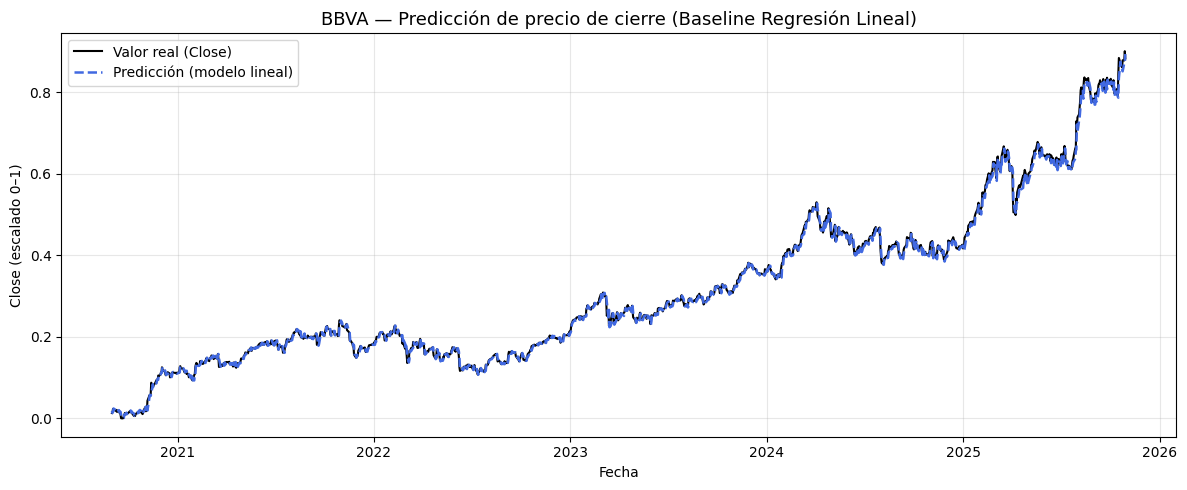

In [2]:
# ============================================
# 0) Imports
# ============================================
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================
# 1) Configuración de paths y lectura
# ============================================
RESULTS_DIR = Path("../results/baseline_regression")
TICKER = "BBVA"  # cambia a "SAN" si quieres ver el otro

preds_path = RESULTS_DIR / f"{TICKER}_baseline_predictions.csv"
df_preds = pd.read_csv(preds_path, parse_dates=["Date"], index_col="Date")

# ============================================
# 2) Gráfico temporal de valores reales vs predichos
# ============================================
plt.figure(figsize=(12,5))
plt.plot(df_preds.index, df_preds["Real_Close"], label="Valor real (Close)", color="black", linewidth=1.5)
plt.plot(df_preds.index, df_preds["Predicted_Close"], label="Predicción (modelo lineal)", color="royalblue", linestyle="--", linewidth=1.8)
plt.title(f"{TICKER} — Predicción de precio de cierre (Baseline Regresión Lineal)", fontsize=13)
plt.xlabel("Fecha")
plt.ylabel("Close (escalado 0–1)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


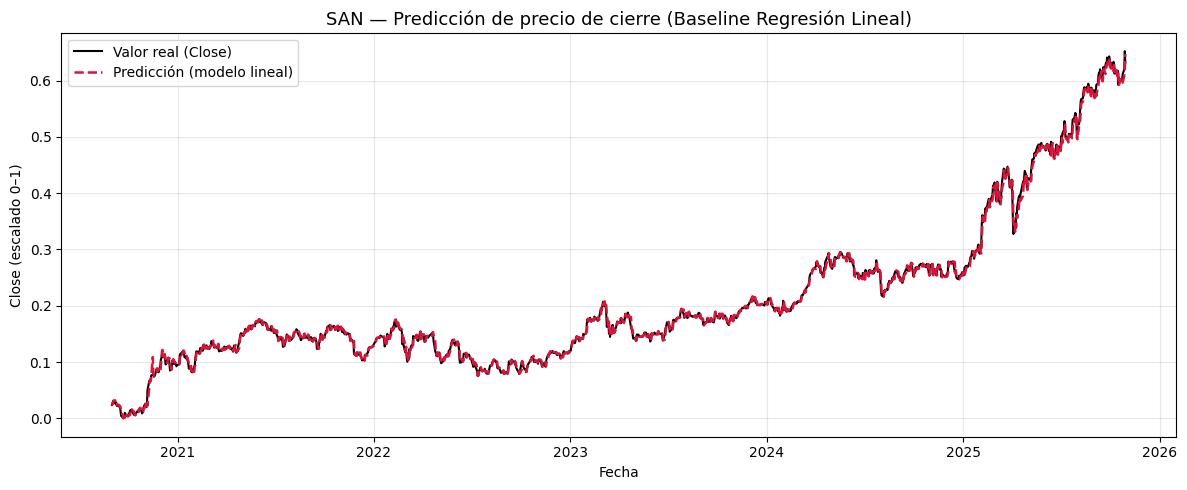

In [3]:
# ============================================
# 0) Imports
# ============================================
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================
# 1) Configuración de paths y lectura
# ============================================
RESULTS_DIR = Path("../results/baseline_regression")
TICKER = "SAN"

preds_path = RESULTS_DIR / f"{TICKER}_baseline_predictions.csv"
df_preds = pd.read_csv(preds_path, parse_dates=["Date"], index_col="Date")

# ============================================
# 2) Gráfico temporal de valores reales vs predichos
# ============================================
plt.figure(figsize=(12,5))
plt.plot(df_preds.index, df_preds["Real_Close"], label="Valor real (Close)", color="black", linewidth=1.5)
plt.plot(df_preds.index, df_preds["Predicted_Close"], label="Predicción (modelo lineal)", color="crimson", linestyle="--", linewidth=1.8)
plt.title(f"{TICKER} — Predicción de precio de cierre (Baseline Regresión Lineal)", fontsize=13)
plt.xlabel("Fecha")
plt.ylabel("Close (escalado 0–1)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Aunque las gráficas de predicción muestran una coincidencia casi perfecta entre los valores reales y las estimaciones, este resultado debe interpretarse con cautela.  
El modelo de regresión lineal utilizado constituye una **línea base (baseline)** que predice únicamente el **precio de cierre del día siguiente (t+1)**.

Debido a que el precio de cierre de un día está fuertemente correlacionado con el del día anterior, la regresión lineal puede reproducir la forma general de la serie con gran precisión.  
Sin embargo, esta capacidad **no implica una verdadera predicción a futuro**, sino una extrapolación inmediata basada en la continuidad de los datos.

Por esta razón, el modelo lineal no resulta adecuado para predicciones de mayor horizonte (t+5, t+10, etc.), ya que los errores se acumulan rápidamente y el modelo carece de memoria temporal.  
Modelos más avanzados, como las redes neuronales recurrentes **LSTM** o **GRU**, serán necesarios para capturar las dependencias secuenciales y los patrones dinámicos del mercado.
